<a href="https://colab.research.google.com/github/shere-khan/machine_learning/blob/master/SimpleGANPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
# makes pixel values between -1 and 1.
# Assume they are transformed from (0, 1)
# map 1 -> 1 and 0 -> -1
# min value = (0 - 0.5) / 0.5 = -1
# max value = (1 - 0.5) / 0.5 = +1
# research foound using pixel values in range
# [-1, +1] works better
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),
                         std=(0.5,))])

train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transform,
    download=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
len(train_dataset)

60000

In [4]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

In [5]:
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(.2),
    nn.Linear(256, 1),
    nn.LeakyReLU(.2)
)

In [6]:
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(.2),
    nn.BatchNorm1d(256, momentum=.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(.2),
    nn.BatchNorm1d(512, momentum=.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(.2),
    nn.BatchNorm1d(1024, momentum=.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)

In [7]:
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
D = D.to(device)
G = G.to(device)

In [8]:
# Loss and optimizers
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=.0002, betas=(.5, .999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=.0002, betas=(.5, .999))

In [9]:
# map image from [-1, +1] -> [0, 1]
def scale_image(img):
  out = (img + 1) / 2
  return out

In [10]:
import os

# create folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [12]:
# training loop

# labels to use in the loop
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)

# save losses
d_losses = []
g_losses = []

for epoch in range(10):
  for inputs, _ in data_loader:
    # don't need targets

    # reshape and move to gpu
    # because batch size might not divide the total
    # data evenly, the actual batch size might
    # be different than the specified batch size
    n = inputs.size(0)
    inputs = inputs.reshape(n, 784).to(device)

    # set ones and zeros to correct size
    ones = ones_[:n]
    zeros = zeros_[:n]


    ################## TRAIN DISCRIMINATOR ###############

    # real images
    real_outputs = D(inputs)

    # push discriminator in the direction of 
    # classifying real images as real
    d_loss_real = criterion(real_outputs, ones)

    # fake images
    noise = torch.randn(n, latent_dim).to(device)
    fake_images = G(noise)
    fake_outputs = D(fake_images)

    # push discriminator in the direction of 
    # classifying fake images as fake
    d_loss_fake = criterion(fake_outputs, zeros)

    # gradient descent step
    d_loss = .5 * (d_loss_real + d_loss_fake) # combine losses as avg
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

    # Train discriminator only
    d_loss.backward()
    d_optimizer.step()

    ################## TRAIN GENERATOR ###############

    # Train generator twice per epoch
    for _ in range(2):
      # fake images
      noise = torch.randn(n, latent_dim).to(device)
      fake_images = G(noise)
      fake_outputs = D(fake_images)

      # reverse the labels
      # push weights generator in the direction of 
      # generating more realistic fakes
      g_loss = criterion(fake_outputs, ones)

      # gradient descent step
      d_optimizer.zero_grad()
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()
    
    # save losses
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

  ### print and save ###
  print(f"Epoch: {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")
  
  # use pytorch function to save a batch of images to file
  fake_images = fake_images.reshape(-1, 1, 28, 28)
  # must first scale images  back to correct range before saving
  save_image(scale_image(fake_images), f"gan_images/{epoch+1}.png")

Epoch: 0, d_loss: 0.6904945373535156, g_loss: 0.6983795166015625
Epoch: 1, d_loss: 0.6866699457168579, g_loss: 0.6596412658691406
Epoch: 2, d_loss: 0.6883202791213989, g_loss: 0.6854783296585083
Epoch: 3, d_loss: 0.6959060430526733, g_loss: 0.6898161768913269
Epoch: 4, d_loss: 0.694151759147644, g_loss: 0.6711086630821228
Epoch: 5, d_loss: 0.6940973401069641, g_loss: 0.6211397647857666
Epoch: 6, d_loss: 0.6925629377365112, g_loss: 0.7081506252288818
Epoch: 7, d_loss: 0.6892551183700562, g_loss: 0.6664168238639832
Epoch: 8, d_loss: 0.693032443523407, g_loss: 0.6825976371765137
Epoch: 9, d_loss: 0.6894360780715942, g_loss: 0.6593753099441528


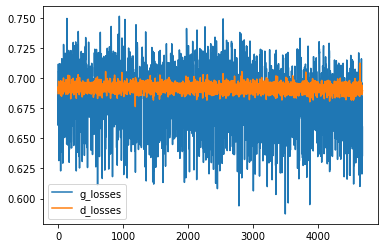

In [13]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

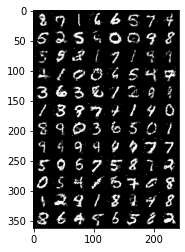

In [15]:
from skimage.io import imread
a = imread('gan_images/10.png')
plt.imshow(a)